In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage

from wavefront2d.initialize import *
from wavefront2d.visualize import *
from wavefront2d.patch import *
from wavefront2d.point import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

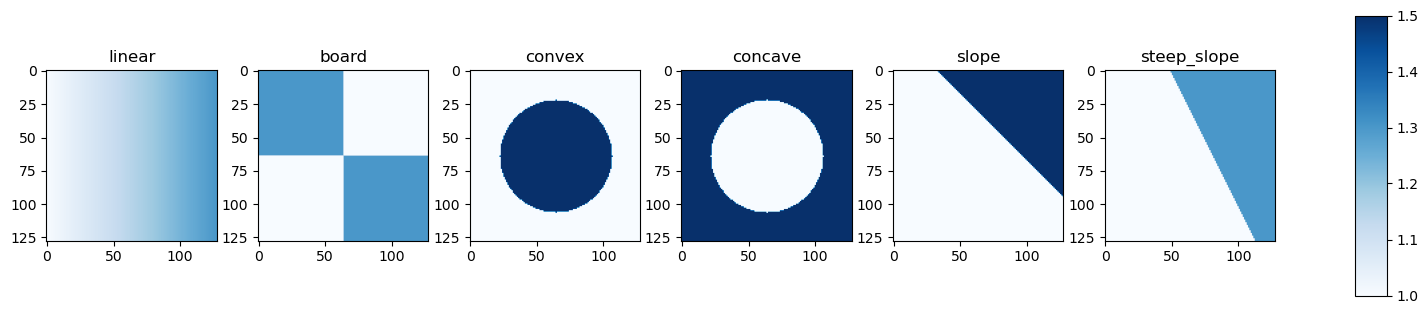

In [10]:
field_size = 128

linear_ior_field = get_ior_field("linear")
board_ior_field = get_ior_field("board")
convex_ior_field = get_ior_field("convex")
concave_ior_field = get_ior_field("concave")
slope_ior_field = get_ior_field("slope")
steep_slope_ior_field = get_ior_field("steep_slope")

visualize_ior_fields([linear_ior_field, board_ior_field, convex_ior_field, concave_ior_field, slope_ior_field, steep_slope_ior_field],
                      ["linear", "board", "convex", "concave", "slope", "steep_slope"])

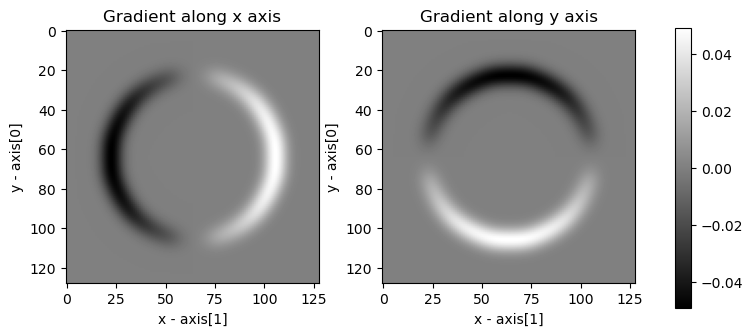

In [11]:
grad_x, grad_y = compute_gradients(concave_ior_field)
visualize_gradients(grad_x, grad_y)

## 2. Adaptive wavefront propagation

In [12]:
# Initialize wavefront using Points
initial_wavefront_positions = [(0, i) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1, 0) for _ in range(field_size)]  # initial directions are all to the right

# Initialize wavefront using Patches
initial_wavefront_patches = init_wavefront_patches(initial_wavefront_positions, initial_wavefront_directions)

num_steps = int(field_size * 3)
delta_t = 0.6
num_show_images = 3

ior_field_dict = {
    'linear': {'ior': linear_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    'board': {'ior': board_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    'convex_lens': {'ior': convex_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    'concave_lens': {'ior': concave_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None, 'simp_irradiance': None},
    # 'slope': {'ior': slope_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None},
    # 'steep_slope': {'ior': steep_slope_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 'irradiance': None, 'dir_vec': None}
}

### (1) Patch-based wavefront propagation

In [13]:
for key, value in ior_field_dict.items():
#     wavefront_patches = simulate_wavefront_propagation_patches(value['ior'], initial_wavefront_patches, num_steps, delta_t)
#     value['patches_list'] = wavefront_patches
#     visualize_wavefront_propagation_patches(wavefront_patches, value['ior'], num_show_images)
    value["irradiance"] = accumulate_patches(value['ior'], initial_wavefront_patches, num_steps, delta_t)

### (2) Point-based wavefront propagation

In [14]:
for key, value in ior_field_dict.items():
#     wavefront_pos_list, wavefront_dir_list = simulate_wavefront_propagation_points(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)
#     value['pos'] = wavefront_pos_list
#     value['dir'] = wavefront_dir_list
#     visualize_wavefront_propagation_points(wavefront_pos_list, wavefront_dir_list, value['ior'], num_steps, num_show_images)
    value["simp_irradiance"] = accumulate_points(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)

## 3. Calculate irradiance $\Delta E_{\omega}$

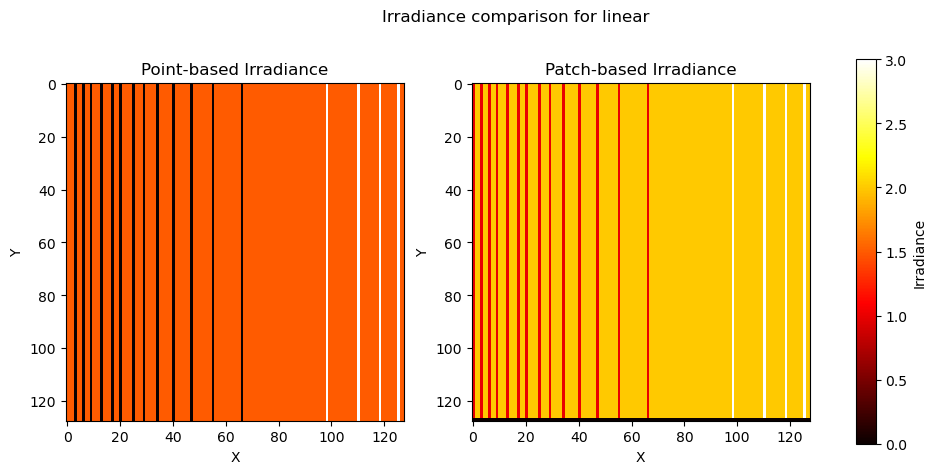

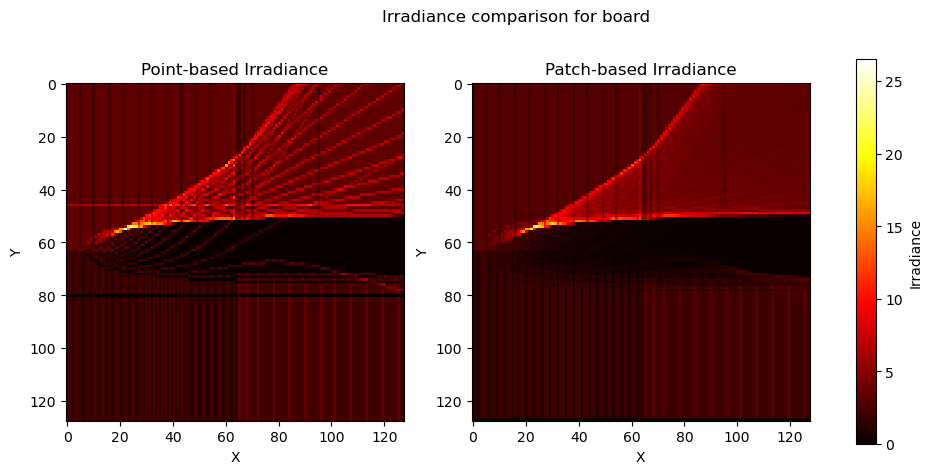

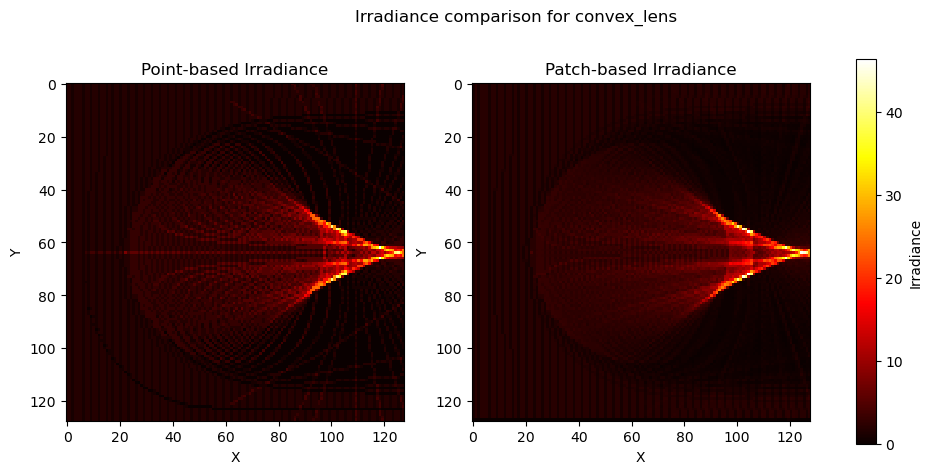

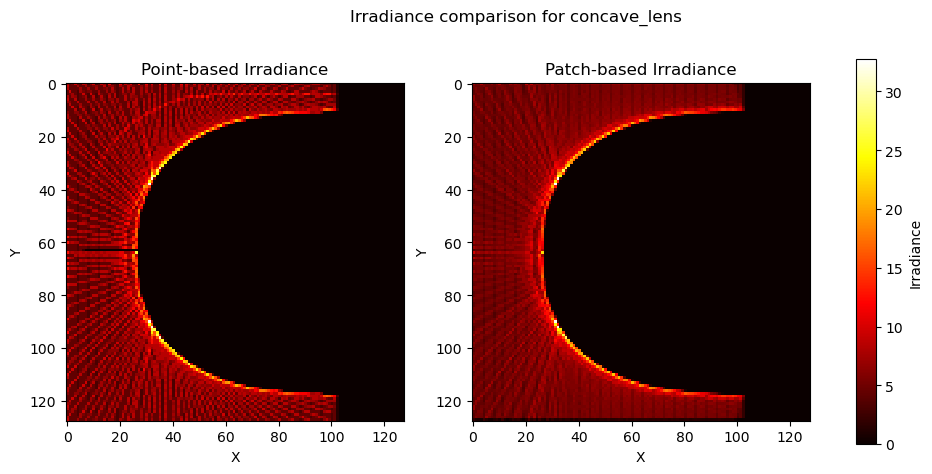

In [15]:
for key, value in ior_field_dict.items():
    simple_irradiance = value["simp_irradiance"]
    patches_irradiance = value["irradiance"]
    visualize_irradiance(simple_irradiance, patches_irradiance, f"Irradiance comparison for {key}")

In [ ]:
# for key, value in ior_field_dict.items():
#     simple_irradiance = compute_irradiance_points(value['pos'], field_size) #  np.zeros((field_size, field_size)) #  
#     patch_irradiance = compute_irradiance_patches(value['patches_list'], field_size)
#     visualize_irradiance(simple_irradiance, patch_irradiance, f'Irradiance for {key} IOR Field')
    
#     value['irradiance'] = patch_irradiance
#     value['simp_irradiance'] = simple_irradiance

# for key, value in ior_field_dict.items():
    
#     irradiance = value['irradiance']
#     simple_irradiance = value['simp_irradiance']
    
#     # Gaussian filter the irradiance
#     filtered_irradiance = ndimage.gaussian_filter(irradiance, sigma=5.0)
#     # Subsample each irradiance to 256*256 using library function
#     subsampled_irradiance = ndimage.zoom(filtered_irradiance, 0.5, order=1)

#     simp_filtered_irradiance = ndimage.gaussian_filter(simple_irradiance, sigma=5.0)
#     simp_subsampled_irradiance = ndimage.zoom(simp_filtered_irradiance, 0.5, order=1)

#     visualize_irradiance(simp_subsampled_irradiance, subsampled_irradiance, f'Subsampled Irradiance for {key} IOR Field')

## 5. Store irradiance into quad tree

In [ ]:
tester = "convex_lens"
test_irradiance = ior_field_dict[tester]['irradiance']

In [ ]:
class Node:
    def __init__(self, val: int = 0, top_left=None, top_right=None, bottom_left=None, bottom_right=None):
        self.val = val
        self.top_left = top_left
        self.top_right = top_right
        self.bottom_left = bottom_left
        self.bottom_right = bottom_right
    
    @property
    def is_leaf(self):
        return all(child is None for child in (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
    
    def __repr__(self):
        return self._repr_recursive()

    def _repr_recursive(self, depth=0, max_depth=2):
        indent = "  " * depth
        if self.is_leaf:
            return f"{indent}Node(val={self.val})"
        else:
            if depth >= max_depth:
                return f"{indent}Node(...)"
            children_repr = ",\n".join(self._repr_recursive_child(child, depth + 1, max_depth) for child in 
                                       (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
            return f"{indent}Node(\n{children_repr})"

    def _repr_recursive_child(self, child, depth, max_depth):
        return "  " * depth + "None" if child is None else child._repr_recursive(depth, max_depth)

class QuadTree:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
    
    def construct(self, grid: np.ndarray) -> None:
        self.root = self._build_tree(grid, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def _build_tree(self, grid: np.ndarray, i: int, j: int, size: int) -> Node:
        if self._is_homogeneous(grid, i, j, size):
            return Node(grid[i, j])

        half_size = size // 2
        top_left = self._build_tree(grid, i, j, half_size)
        top_right = self._build_tree(grid, i, j + half_size, half_size)
        bottom_left = self._build_tree(grid, i + half_size, j, half_size)
        bottom_right = self._build_tree(grid, i + half_size, j + half_size, half_size)
        
        if top_left.is_leaf and top_right.is_leaf and bottom_left.is_leaf and bottom_right.is_leaf:
            values = {node.val for node in (top_left, top_right, bottom_left, bottom_right)}
            if len(values) == 1:
                return Node(values.pop())
        
        return Node(top_left=top_left, top_right=top_right, bottom_left=bottom_left, bottom_right=bottom_right)
    
    def _is_homogeneous(self, grid: np.ndarray, i: int, j: int, size: int) -> bool:
        return np.ptp(grid[i:i+size, j:j+size]) <= self.threshold

    def query(self, x: int, y: int) -> int:
        return self._query(self.root, 0, 0, self.grid_size, x, y)

    def _query(self, node: Node | None, i: int, j: int, size: int, x: int, y: int) -> int:
        if node is None:
            raise ValueError("QuadTree is empty. Maybe you forgot to construct it?")
        
        if node.is_leaf:
            return node.val

        half_size = size // 2
        if x < i + half_size:
            if y < j + half_size:
                return self._query(node.bottom_left, i, j, half_size, x, y)
            else:
                return self._query(node.top_left, i, j + half_size, half_size, x, y)
        else:
            if y < j + half_size:
                return self._query(node.bottom_right, i + half_size, j, half_size, x, y)
            else:
                return self._query(node.top_right, i + half_size, j + half_size, half_size, x, y)
    
    def __len__(self):
        return self._count_nodes(self.root)
    
    def _count_nodes(self, node: Node | None) -> int:
        if node is None:
            return 0
        return 1 + sum(self._count_nodes(child) for child in 
                       (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def __sizeof__(self):
        return self._calculate_memory_usage(self.root)
    
    def _calculate_memory_usage(self, node: Node | None) -> int:
        if node is None:
            return 0
        return sys.getsizeof(node) + sum(self._calculate_memory_usage(child) for child in 
                                         (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def visualize(self, figsize=(20, 20)):
        plt.figure(figsize=figsize)
        self._visualize_node(self.root, 0, 0, self.grid_size)
        plt.axis('equal')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.tight_layout()
        plt.title('Quad Tree Visualization')
        plt.show()
        
    def _visualize_node(self, node: Node | None, x: float, y: float, size: float):
        if node is None:
            return
        if node.is_leaf:
            rect = patches.Rectangle((x, y), size, size, linewidth=1, edgecolor='black', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x + size / 2, y + size / 2, str(int(node.val)), ha='center', va='center', fontsize=8)
        else:
            half_size = size / 2
            self._visualize_node(node.top_left, x, y + half_size, half_size)
            self._visualize_node(node.top_right, x + half_size, y + half_size, half_size)
            self._visualize_node(node.bottom_left, x, y, half_size)
            self._visualize_node(node.bottom_right, x + half_size, y, half_size)



quad_tree = QuadTree(threshold=4) 
quad_tree.construct(test_irradiance)

value = quad_tree.query(60, 60)
print(f"Query value at (0, 99): {value}")

node_count = len(quad_tree)
print(f"Number of nodes: {node_count}")

memory_usage = sys.getsizeof(quad_tree)
print(f"Memory Usage: {memory_usage} bytes")
print(f"In comparison, NumPy Storage Usage: {test_irradiance.nbytes} bytes")

quad_tree.visualize()

In [ ]:
# plt show test_irradiance and write its each element specific int value
plt.figure(figsize=(20, 20))
plt.imshow(test_irradiance, cmap='hot', interpolation='nearest')
for i in range(test_irradiance.shape[0]):
    for j in range(test_irradiance.shape[1]):
        plt.text(j, i, str(int(test_irradiance[i, j])), ha='center', va='center', color='black', fontsize=7)
plt.colorbar(label='Irradiance')
plt.title('Test Irradiance')
plt.show()